This notebook consists of 3 parts:

Cleaning and preprocessing our data

Content-based filtering (here we use 'overview' of every movie, credits.csv data set)

Colaborative filtering (here we use additional data set ratings.csv)

As a result, I've achieved a model, which ouputs movies for a User, which he/she hasn't rated (this model will be in the next tutorial).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df1 = pd.read_csv('/content/drive/My Drive/movies_metadata.csv') # in the beginning import these data sets
df2 = pd.read_csv('/content/drive/My Drive/credits.csv')

In [3]:
df1.shape, sum(df1.id.str.isdigit()) # need to convert 'id' column to integer

((45466, 24), 45463)

In [5]:
df1 = df1[df1.id.str.isdigit()] # keep only digits

In [6]:
df1 = df1.astype({'id':'int64'})

In [7]:
df = df1.merge(df2, on='id') # merge two tables

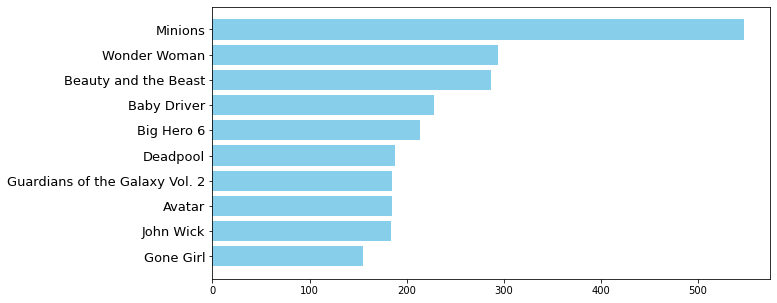

In [32]:
df = df.astype({'popularity':'float64'}) # let's look at the most popular movies
popular_movies = df.sort_values(by='popularity', ascending=False)
plt.figure(figsize=(10,5))
plt.barh(popular_movies.title.head(10),popular_movies.popularity.head(10), color='skyblue')
plt.yticks(size=13)
plt.gca().invert_yaxis()

In [172]:
C = df.vote_average.mean() 
# this trick I took from Kaggle: we need to calculate 
# weighted rating based in 'vote_count' and 'vote_average'
C

5.61823212913114

In [10]:
df.dropna(subset=['vote_count'], inplace=True)

In [272]:
# we should bare in mind duplicated movie's id in order not to make a mistake
df.drop_duplicates('id',ignore_index=True, inplace=True)
sum(df.duplicated('id')), df.shape

(0, (45429, 30))

In [273]:
df.index # check index

RangeIndex(start=0, stop=45429, step=1)

In [274]:
m = df.vote_count.quantile(0.9) 
# we'll keep inly those ratings, where at least there are 160 votes
m

160.0

In [275]:
qualified_df = df[df.vote_count >= m]

In [276]:
df.shape, qualified_df.shape # now we have 10 times less data

((45429, 30), (4551, 30))

In [278]:
qualified_df.index = range(0,4551) # as indices were not in the appropriate order
qualified_df.index

RangeIndex(start=0, stop=4551, step=1)

In [ ]:
qualified_df.head()

In [280]:
def weighted_rating(x, m=m, C=C):
    R = x['vote_average']
    v = x['vote_count']
    # based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified_df['weighted_rating'] = qualified_df.apply(weighted_rating, axis=1)

In [282]:
qualified_df.loc[:,['title','vote_average', 'weighted_rating']].head()

,title,vote_average,weighted_rating
0,Toy Story,7.7,7.640254
1,Jumanji,6.9,6.820294
2,Father of the Bride Part II,5.7,5.660712
3,Heat,7.7,7.537203
4,Sudden Death,5.5,5.556638


**Content-based filtering**

In [283]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
qualified_df.overview = qualified_df['overview'].fillna('') 
# we'll use 'overview' column as a content
tfidf_matrix = tfidf.fit_transform(qualified_df['overview'])
tfidf_matrix.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(4551, 19694)

In [284]:
from sklearn.metrics.pairwise import linear_kernel 
# we'll calculate the distance using cosine similarity, as the documenattion says: 
# if you use TFIDF vectorizer, which returns normalized rows, 
# you should make only a dot product of matrices rather than the whole calculation of cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [285]:
# we'll make a function whose input is 'title' of the movie and ouput  is most similar to this movie movies
indices = pd.Series(qualified_df.index, index=qualified_df.title) 

In [286]:
indices.head()

title
Toy Story                      0
Jumanji                        1
Father of the Bride Part II    2
Heat                           3
Sudden Death                   4
dtype: int64

In [38]:
def common_10_movies(title):
  idx = indices[title]
  similarities = list(enumerate(cosine_sim[idx]))
  similarities = sorted(similarities, key= lambda x: x[1], reverse=True)
  similarities = similarities[1:11] # as the 1st similarity is with itself
  sim_indices = [x[0] for x in similarities]
  return qualified_df.title.iloc[sim_indices], [x[1] for x in similarities]

In [287]:
movies, scores = common_10_movies('The Dark Knight')

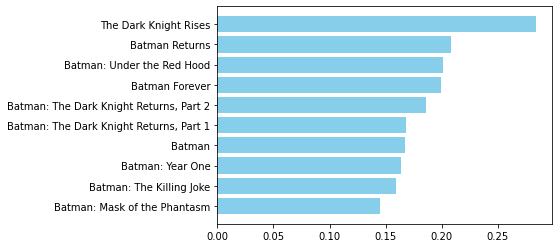

In [288]:
plt.barh(movies, scores, color='skyblue') 
plt.gca().invert_yaxis()
# so this simple model returns only movies about Batman, 
# let's make it more complex: i.g. include director of the movie, top actors and etc.

**Using mixed information about movie as its content**

In [ ]:
from ast import literal_eval # as these columns are strings of list of dicts
features = ['cast', 'crew',  'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval) # attention: we switched to our first dataframe

In [50]:
def get_director(x): 
    """ 
    This function we'll give a Series of directors of the movie
    """
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return None
def get_list(x):
    """ 
    This function we'll give a Series of top-3 of the particular properties of the movie
    """
    if isinstance(x, list):
      names = [i['name'] for i in x]
      if len(names) > 3:
        names = names[:3]
      return names
    return None

In [51]:
df['directors'] = df.crew.apply(get_director)
features = ['cast', 'genres']
for feature in features:
    df[feature] = df[feature].apply(get_list)

In [56]:
def lower_strip(x): # make our text data more appropriate for the recommendation model
  if isinstance(x,list):
    # if we leave our actors' names with space, 
    # then recommender will consist 'Tom Haks' and 'Tom Hardy' as the same, 
    # so we should merge actors' 1st and last names
    return [str.lower(i.replace(" ", "")) for i in x] 
  elif isinstance(x,str): # for directors
    return str.lower(x.replace(" ", ""))
  else:
    return None

In [57]:
features = ['cast', 'genres', 'directors']
for feature in features:
    df[feature] = df[feature].apply(lower_strip)

In [290]:
df.loc[:, ['title', 'cast', 'genres','directors']].head(5)

,title,cast,genres,directors
0,Toy Story,"[tomhanks, timallen, donrickles]","[animation, comedy, family]",johnlasseter
1,Jumanji,"[robinwilliams, jonathanhyde, kirstendunst]","[adventure, fantasy, family]",joejohnston
2,Grumpier Old Men,"[waltermatthau, jacklemmon, ann-margret]","[romance, comedy]",howarddeutch
3,Waiting to Exhale,"[whitneyhouston, angelabassett, lorettadevine]","[comedy, drama, romance]",forestwhitaker
4,Father of the Bride Part II,"[stevemartin, dianekeaton, martinshort]",[comedy],charlesshyer


In [59]:
def concatenate(x): # concatenate three columns into one
  try:
    return ' '.join(x.cast)+' '+' '.join(x.genres)+' '+x.directors
  except: # as we have empty data in 'directors'
    return ' '.join(x.cast)+' '+' '.join(x.genres)

In [60]:
df['mixed_info'] = df.apply(concatenate,axis=1)

In [291]:
df.mixed_info.head()

0    tomhanks timallen donrickles animation comedy ...
1    robinwilliams jonathanhyde kirstendunst advent...
2    waltermatthau jacklemmon ann-margret romance c...
3    whitneyhouston angelabassett lorettadevine com...
4    stevemartin dianekeaton martinshort comedy cha...
Name: mixed_info, dtype: object

In [293]:
links = pd.read_csv('/content/drive/My Drive/datasets_3405_6663_links_small.csv') # we'll be using another one data set
links.isna().sum()

movieId     0
imdbId      0
tmdbId     13
dtype: int64

In [295]:
links.duplicated('tmdbId').sum()

12

In [296]:
links.drop_duplicates('tmdbId',inplace=True, ignore_index=True)
links.duplicated('tmdbId').sum()

0

In [297]:
links.dropna(subset=['tmdbId'], inplace=True)

In [298]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
links.tmdbId = links.tmdbId.apply(convert_int)
links.shape, (df[df.id.isin(links.tmdbId)]).shape

((9112, 3), (9082, 30))

In [492]:
df_links = df[df.id.isin(links.tmdbId)] # consider only those 'id' which are in 'tmdbId'

In [493]:
df_links.duplicated('id').sum() # check

0

In [494]:
df_links.index # we should change indices

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            39588, 39632, 39638, 39721, 39740, 39753, 39973, 40026, 40192,
            40470],
           dtype='int64', length=9082)

In [495]:
df_links.index = range(0,9082)

In [ ]:
duplicated_indices = df_links.title[df_links.duplicated('title', keep=False)].index
df_links.release_date = pd.to_datetime(df_links.release_date)
duplicated_data = df_links.loc[duplicated_indices, ['title','release_date']].sort_values(by=['title','release_date'])
duplicated_data['title_year'] = duplicated_data.title +' '+duplicated_data.release_date.dt.year.astype('str')

In [497]:
len(duplicated_data.title_year.unique()) # we have 520 unique values instead of 521

520

In [498]:
duplicated_data[duplicated_data.title_year.duplicated(keep=False)] # 'Hamlet' was produced twice in the same year

,title,release_date,title_year
2867,Hamlet,2000-05-12,Hamlet 2000
7131,Hamlet,2000-12-10,Hamlet 2000


In [499]:
duplicated_data.loc[7131,['title_year']] = 'Hamlet 2000, 2'
len(duplicated_data.title_year.unique()) # check

521

In [ ]:
duplicated_data.sort_index(inplace=True)
df_links.loc[duplicated_indices,'title'] = duplicated_data.title_year

In [501]:
df_links.loc[duplicated_indices,'title']

6            Sabrina 1995
25           Othello 1995
27        Persuasion 1995
54       The Postman 1994
66         Fair Game 1995
              ...        
8958          Legend 2015
8970         Everest 2015
9014         Sisters 2015
9043            Hush 2016
9059    Ghostbusters 2016
Name: title, Length: 521, dtype: object

In [502]:
from sklearn.feature_extraction.text import CountVectorizer
# we'll use CountVectorizer instead of TFIDF, because we needn't penalize words
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_links.mixed_info) # this column - our content
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(count_matrix, count_matrix)

In [503]:
cos_sim.shape

(9082, 9082)

In [504]:
indices_2 = pd.Series(df_links.index, index=df_links.title) # the same approch as in the previous model

In [505]:
indices_2

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9077
Rustom                                                9078
Mohenjo Daro                                          9079
Shin Godzilla                                         9080
The Beatles: Eight Days a Week - The Touring Years    9081
Length: 9082, dtype: int64

In [310]:
m = df_links.vote_count.quantile(0.85)
def common_10_movies_modified(title, result='barplot'): # a little bit modified function
  """
  Choose the type of the result: whether you want a simple chart (write 'table' as the 2nd argument) 
  or a tuple of movies and corresponding weigthed ratings
  """
  idx = indices_2[title]
  similarities = list(enumerate(cos_sim[idx]))
  similarities = sorted(similarities, key= lambda x: x[1], reverse=True)
  similarities = similarities[1:11]
  sim_indices = [x[0] for x in similarities]
  # add to the report weigthed rating according to IMDB calculation
  movies = df_links.iloc[sim_indices][['title','vote_count','vote_average']]
  movies['w_r'] = (movies['vote_count']/(movies['vote_count']+m) * movies['vote_average']) + (m/(m+movies['vote_count'])*movies['vote_average'].mean())
  movies.sort_values('w_r',ascending=False, inplace=True)
  if result == 'table':
    return movies 
  return df_links.title.iloc[sim_indices], [x[1] for x in similarities]

In [311]:
common_10_movies_modified('Mean Girls', 'table')

,title,vote_count,vote_average,w_r
1616,The Parent Trap,768.0,6.8,6.312684
6200,Just Like Heaven,595.0,6.5,6.114340
4707,Freaky Friday,919.0,6.0,5.911461
1308,The House of Yes,30.0,6.3,5.819737
3157,The Ladies Man,35.0,5.7,5.795425
3298,Head Over Heels,73.0,5.3,5.754545
7800,Mr. Popper's Penguins,775.0,5.7,5.748505
4381,The Hot Chick,431.0,5.5,5.688630
5096,Confessions of a Teenage Drama Queen,228.0,5.1,5.633403
6144,Herbie Fully Loaded,559.0,5.1,5.496431


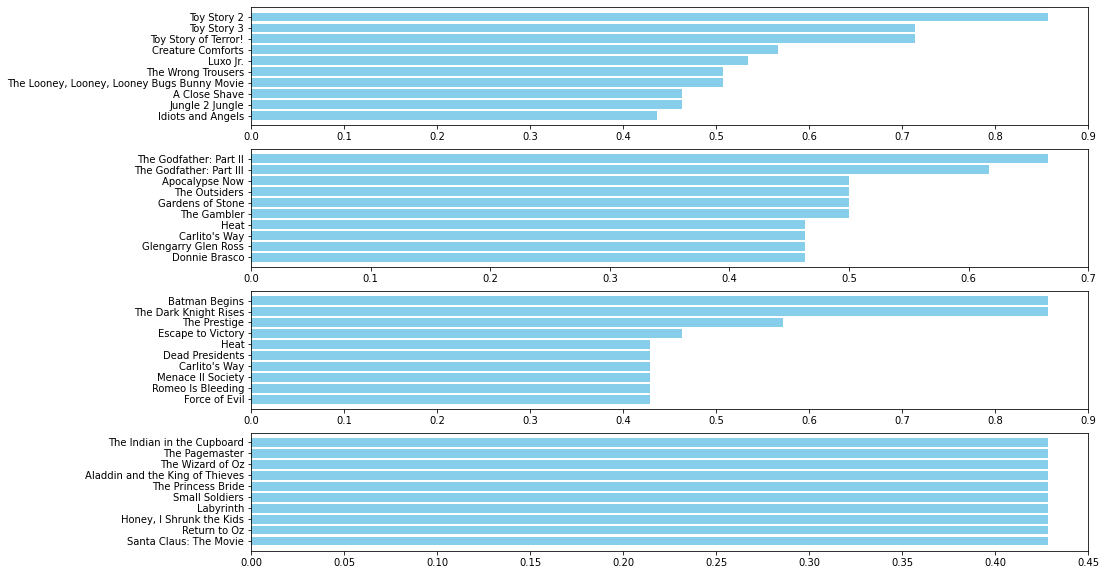

In [312]:
movies_list = ['Toy Story', 'The Godfather', 'The Dark Knight', 'Jumanji']
fig, ax = plt.subplots(4,1, figsize=(15,10))
i = 0
for name in movies_list:
  movies, scores = common_10_movies_modified(name)
  ax[i].barh(movies, scores, color='skyblue')
  ax[i].invert_yaxis()
  i += 1

As you can see this filter is doing better job by considering actors and other stuff. Unfortunately, this filter doesn't consider persons' tastes. We'll improve our filter in the next part.

**Collaborative filtering**

In [108]:
!pip -q install surprise # we'll be using surprise module which is already made for user/item-based filtering

     |████████████████████████████████| 6.5MB 2.8MB/s 


In [109]:
from surprise import Dataset, SVD, Reader

In [110]:
ratings = pd.read_csv('/content/drive/My Drive/ratings_small.csv')

In [111]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [112]:
reader = Reader()
dataset = Dataset.load_from_df(ratings.iloc[:,:3], reader)

In [113]:
svd = SVD()

In [114]:
dataset = dataset.build_full_trainset()
svd = svd.fit(dataset)

In [115]:
svd.predict(1, 302, 3) 
# the prediction for user 1 for a movie's index 302 is 2.81 which is close to the true value 3

Prediction(uid=1, iid=302, r_ui=3, est=2.81699705229459, details={'was_impossible': False})

**Combined model**

We'll use trained SVD in this model. Given UserId and Title of the movie it outputs a table of movies, which User is probably going to like based on his ratings for other movies.

In [116]:
links.head() # remember our links data set

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [ ]:
id_map = links.iloc[:,[0,2]] 
id_map.rename(columns={'tmdbId':'id'},inplace=True)

In [314]:
id_map.head()

,movieId,id
0,1,862
1,2,8844
2,3,15602
3,4,31357
4,5,11862


In [316]:
id_map.id.duplicated().sum() # check

0

In [459]:
id_map = id_map.merge(df_links[['title','id']], on='id')

In [462]:
id_map = id_map.set_index('title')

In [463]:
id_map.shape

(9082, 2)

In [507]:
id_map.head()

,movieId,id
title,,
Toy Story,1,862
Jumanji,2,8844
Grumpier Old Men,3,15602
Waiting to Exhale,4,31357
Father of the Bride Part II,5,11862


In [470]:
id_movieId = id_map.set_index('id')

In [471]:
id_movieId.head()

,movieId
id,
862,1
8844,2
15602,3
31357,4
11862,5


In [472]:
def combined_model(userId, title):
  """
  Given UserId and Title of the movie it outputs a table of movies, 
  which User is probably going to like, based on his ratings for other movies.
  """
  idx = indices_2[title]
  sim_scores = list(enumerate(cos_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11]
  movie_indices = [i[0] for i in sim_scores]
  movies = df_links.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
  # using our trained SVD on ratings dataset
  movies['estimated'] = movies['id'].apply(lambda x: svd.predict(userId, id_movieId.loc[x]['movieId']).est) 
  movies = movies.sort_values('estimated', ascending=False)
  return movies

In [473]:
combined_model(234,'Avatar').head() 

,title,vote_count,vote_average,id,estimated
1220,The Fifth Element,3962.0,7.3,18,3.992602
953,Aliens,3282.0,7.7,679,3.954964
901,The Abyss,822.0,7.1,2756,3.764226
1025,Highlander,642.0,6.8,8009,3.694991
1255,Conan the Barbarian,663.0,6.6,9387,3.547194


If you try different users, you'll see that a list of movies is the same, but estimated ratings, which user is probably going to give are different.

In [133]:
combined_model(76,'The Godfather').head() 

,title,vote_count,vote_average,id,estimated
982,The Godfather: Part II,3418.0,8.3,240,4.711210
969,Apocalypse Now,2112.0,8.0,28,4.310452
1192,Donnie Brasco,1175.0,7.4,9366,4.122397
892,Glengarry Glen Ross,330.0,7.5,9504,3.930311
5,Heat,1886.0,7.7,949,3.832404


In [153]:
combined_model(76,'Forrest Gump').head() 
# user 76 ratings are lower for romantic movies, 
# so we may conclude that he's a fan of 'man' movies

,title,vote_count,vote_average,id,estimated
7848,Larry Crowne,369.0,5.7,59861,3.645765
483,Sleepless in Seattle,630.0,6.5,858,3.629289
1933,Nothing in Common,30.0,6.1,29968,3.585795
850,That Thing You Do!,230.0,6.8,9591,3.466976
1949,Hurlyburly,22.0,5.6,24525,3.321422


In [514]:
popular_movies_age = df_links.loc[duplicated_indices, ['title','popularity']].sort_values('popularity', ascending=False)
popular_movies_age.head(10) # make this table to ease your choice for the appropriate year for the movie

,title,popularity
7864,The Avengers 2012,89.887648
971,Psycho 1960,36.826309
8658,Fury 2014,36.713807
7074,Twilight 2008,31.282029
1355,Titanic 1997,26.889070
2090,The Mummy 1999,23.984065
8920,The Revenant 2015,23.501228
527,Beauty and the Beast 1991,23.433511
6554,Casino Royale 2006,23.065078
1634,The Jungle Book 1967,22.845448


In [510]:
combined_model(76,'Titanic 1997').head() # don't forget to point age for a movie

,title,vote_count,vote_average,id,estimated
16,Sense and Sensibility,364.0,7.2,4584,3.948623
852,Jude,38.0,6.6,25147,3.935516
302,What's Eating Gilbert Grape,943.0,7.5,1587,3.783984
6532,Little Children,243.0,6.9,1440,3.715620
2073,Hideous Kinky,23.0,6.2,10209,3.630958


In [515]:
df_links.to_csv('df_preprocessed_without_duplicates.csv', index=False)

In [518]:
id_map.reset_index().to_csv('id_title.csv', index=False)

So our last recommendation model is the best, we've managed duplicated titles of movies, take into consideration user's preferences. Next we'll try to make our model more independent and propose movies which user haven't rated yet and will like.